# Waves

We will model waves using the wave equation,
$$
    \frac{\partial^2 u}{\partial t^2} = c \frac{\partial^2 u}{\partial x^2},
$$
where $c$ is the speed at which interactions propagate through the medium.

In [1]:
using ModelingToolkit, MethodOfLines, OrdinaryDiffEq, DomainSets
using Plots

In [2]:
@parameters x t
@variables u(..)

Dt = Differential(t)
Dtt = Differential(t)^2
Dxx = Differential(x)^2
;

In [3]:
x_min = t_min = 0.0
x_max = 5.0
t_max = 10.0
;

In [4]:
# Propagation speed of the wave
c = 1.0
;

In [5]:
u0(x, t) = exp(-4*(x-1.5)^2)
du0(x, t) = 0
;

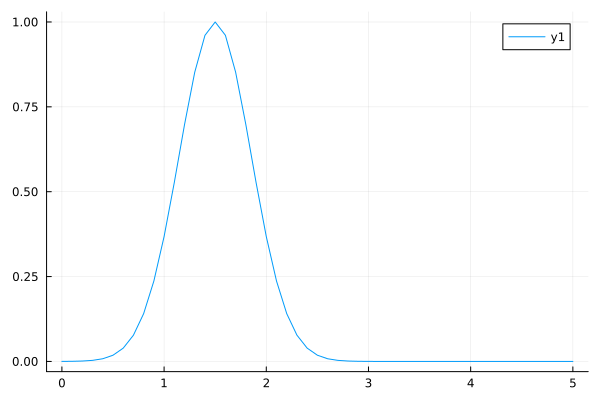

In [6]:
plot(x_min:0.1:x_max, x -> u0(x, 0))

In [7]:
equation = Dtt(u(x, t)) ~ c * Dxx(u(x, t))

Differential(t)(Differential(t)(u(x, t))) ~ Differential(x)(Differential(x)(u(x, t)))

In [8]:
domains = [
    x ∈ Interval(x_min, x_max),
    t ∈ Interval(t_min, t_max)
];

In [9]:
boundary_conditions = [
    u(x, 0) ~ u0(x, 0),
    Dt(u(x, 0)) ~ du0(x, 0),
    u(x_min, t) ~ 0,
    u(x_max, t) ~ 0
]

4-element Vector{Equation}:
 u(x, 0) ~ exp(-4((-1.5 + x)^2))
 Differential(t)(u(x, 0)) ~ 0
 u(0.0, t) ~ 0
 u(5.0, t) ~ 0

In [10]:
@named pde_system = PDESystem(
    equation,
    boundary_conditions,
    domains,
    [x, t],
    [u(x, t)]
)

PDESystem
Equations: Equation[Differential(t)(Differential(t)(u(x, t))) ~ Differential(x)(Differential(x)(u(x, t)))]
Boundary Conditions: Equation[u(x, 0) ~ exp(-4((-1.5 + x)^2)), Differential(t)(u(x, 0)) ~ 0, u(0.0, t) ~ 0, u(5.0, t) ~ 0]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(x, 0.0 .. 5.0), Symbolics.VarDomainPairing(t, 0.0 .. 10.0)]
Dependent Variables: Num[u(x, t)]
Independent Variables: Num[x, t]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [11]:
N = 64

order = 2 # This may be increased to improve accuracy of some schemes

# Integers for x and y are interpreted as number of points. Use a Float to directtly specify stepsizes dx and dy.
discretization = MOLFiniteDifference([x => N], t, approx_order = order)

MOLFiniteDifference{MethodOfLines.CenterAlignedGrid, MethodOfLines.ScalarizedDiscretization}(Dict{Num, Int64}(x => 64), t, 2, UpwindScheme(1), MethodOfLines.CenterAlignedGrid(), true, false, MethodOfLines.ScalarizedDiscretization(), true, Any[], Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}())

In [12]:
println("Discretization:")
@time prob = discretize(pde_system, discretization)

Discretization:
 13.731281 seconds (20.75 M allocations: 1.378 GiB, 3.03% gc time, 96.69% compilation time: 11% of which was recompilation)


ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 124-element Vector{Float64}:
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
  ⋮
  5.309883359214791e-12
  1.0272021039838199e-12
  1.889480837330964e-13
  3.3047967556318823e-14
  5.496202076115999e-15
  8.691531338530907e-16
  1.3069097000558088e-16
  1.8685750027289906e-17
  2.540335985742004e-18
  3.2838813589367143e-19
  4.036448620971538e-20
  4.717664707529003e-21

In [13]:
println("Solve:")
@time solution = solve(prob, Tsit5(), saveat = 0.1)

Solve:
  5.626957 seconds (7.05 M allocations: 454.737 MiB, 2.09% gc time, 99.80% compilation time)


retcode: Success
Interpolation: Dict{Num, Interpolations.GriddedInterpolation{Float64, 2, Matrix{Float64}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{Vector{Float64}, Vector{Float64}}}}
t: 101-element Vector{Float64}:
  0.0
  0.1
  0.2
  0.3
  0.4
  0.5
  0.6
  0.7
  0.8
  0.9
  1.0
  1.1
  1.2
  ⋮
  8.9
  9.0
  9.1
  9.2
  9.3
  9.4
  9.5
  9.6
  9.7
  9.8
  9.9
 10.0ivs: 2-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 t
 xdomain:([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0], 0.0:0.07936507936507936:5.0)
u: Dict{Num, Matrix{Float64}} with 1 entry:
  u(x, t) => [0.0 0.0 … 0.0 0.0; 0.000311904 0.000438324 … 0.000223805 0.000707…

In [ ]:
discrete_t = solution[t]
solution_u = solution[u(x, t)]

animation = @animate for k in 1:length(discrete_t)
    plot(solution_u[1:end, k], title = "$(discrete_t[k])")
end

gif(animation, "wave.gif", fps = 8)